In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn # neural networks define "class"
import torch.nn.functional as F # define "function": 인스턴스화 없이 사용 가능
import torch.optim as optim # 최적화 알고리즘 구현하는 패키지
import torchvision # CV 유명 데이터셋, 모델 아키텍처, 이미지 변형 등 포함하는 패키지

from PIL import Image
from torchvision import transforms, datasets # transforms: 이미지 transformation, datasets: torchvision이 가지고 있는 데이터셋 설명
from torch.utils.data import Dataset, DataLoader 
# Dataset: 샘플과 정답(label) 저장
# DataLoader: Dataset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다

In [8]:
# 에포크, 배치 크기, 디바이스 정의

epochs = 10 # 훈련 반복수
batch_size = 512 # 배치 크기

device = ("cuda" if torch.cuda.is_available() else "cpu") # device 정의
class_names = ['T-shirt/top','Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # 총 10개 클래스

print(torch.__version__)
print(device)

1.12.1+cu102
cuda


In [9]:
# 데이터셋 준비
transform = transforms.Compose([ # Compose: transforms 리스트 구성
    transforms.Resize(227), # 227x227: input image (fashionMNIST's input image: 28x28)
    transforms.ToTensor()]) # ToTensor: PIL image or numpy.ndaray를 tensor로 바꿈

In [12]:
training_data = datasets.FashionMNIST(
    root="data", # data가 저장될 경로(path)
    train=True, # training dataset
    download=True, # 인터넷으로부터 데이터 다운
    transform=transform # feature 및 label 변환(transformation) 지정
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False, # test dataset
    download=True,
    transform=transform
)

In [13]:
# 데이터로더 (DataLoader)
# 데이터를 배치(batch) 단위로 모델에 넣어줌
# (class) DataLoader(dataset, batch_size, shuffle, ...)

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

Shirt


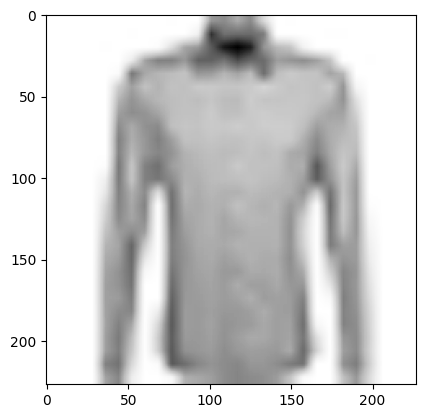

In [15]:
# 이미지 보기
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap='Greys')

# get random training images
dataiter = iter(training_loader)
images, labels = dataiter.next() # next(): 반복할 수 있을 때는 해당 값 출력, 반복 끝났을 때는 기본값 출력

# create grid of images
img_grid = torchvision.utils.make_grid(images[0]) # make_grid: 이미지의 그리드 생성

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

In [23]:
# AlexNet 구현
# 5개 convolution layer, 3개의 fully connected layer

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0), # 흑백, 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out

In [24]:
# 모델 생성
model = AlexNet().to(device)
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters())

In [25]:
# 모델 summary
from torchsummary import summary as summary_

summary_(model, (1, 227, 227), batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 96, 55, 55]          11,712
              ReLU-2          [512, 96, 55, 55]               0
         MaxPool2d-3          [512, 96, 27, 27]               0
            Conv2d-4         [512, 256, 27, 27]         614,656
              ReLU-5         [512, 256, 27, 27]               0
         MaxPool2d-6         [512, 256, 13, 13]               0
            Conv2d-7         [512, 384, 13, 13]         885,120
              ReLU-8         [512, 384, 13, 13]               0
            Conv2d-9         [512, 384, 13, 13]       1,327,488
             ReLU-10         [512, 384, 13, 13]               0
           Conv2d-11         [512, 256, 13, 13]         884,992
             ReLU-12         [512, 256, 13, 13]               0
        MaxPool2d-13           [512, 256, 6, 6]               0
           Linear-14                [51

In [26]:
# train 정의
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [27]:
# test 정의
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [28]:
# 학습 시작하기
for epoch in range(1, epochs+1):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, validation_loader)

Train Epoch: 1 [1856/60000 (3%)]	Loss: 1.322838
Train Epoch: 1 [3776/60000 (6%)]	Loss: 1.008404
Train Epoch: 1 [5696/60000 (9%)]	Loss: 0.710126
Train Epoch: 1 [7616/60000 (13%)]	Loss: 0.769724
Train Epoch: 1 [9536/60000 (16%)]	Loss: 0.555110
Train Epoch: 1 [11456/60000 (19%)]	Loss: 0.489919
Train Epoch: 1 [13376/60000 (22%)]	Loss: 0.773265
Train Epoch: 1 [15296/60000 (25%)]	Loss: 0.828897
Train Epoch: 1 [17216/60000 (29%)]	Loss: 0.395162
Train Epoch: 1 [19136/60000 (32%)]	Loss: 0.513083
Train Epoch: 1 [21056/60000 (35%)]	Loss: 0.489622
Train Epoch: 1 [22976/60000 (38%)]	Loss: 0.561536
Train Epoch: 1 [24896/60000 (41%)]	Loss: 0.448136
Train Epoch: 1 [26816/60000 (45%)]	Loss: 0.475415
Train Epoch: 1 [28736/60000 (48%)]	Loss: 0.312575
Train Epoch: 1 [30656/60000 (51%)]	Loss: 0.632769
Train Epoch: 1 [32576/60000 (54%)]	Loss: 0.513971
Train Epoch: 1 [34496/60000 (57%)]	Loss: 0.505684
Train Epoch: 1 [36416/60000 (61%)]	Loss: 0.189504
Train Epoch: 1 [38336/60000 (64%)]	Loss: 0.566510
Train Ep